# Statistical Pattern Recognition - Solution 7: Classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse_output=False)

## $\star$ Part 1: Generative classifier

Load the data from dataset.npz (you know this dataset already from class 4) and split it evenly into a training set and a test set. 

Train a generative classifier using Gaussian distributions on the training set. (Hint: This comes down to estimating the parameters of a Gaussian distribution
for each class.) 

Then compute the average classification error on the test
set. Compare it to the error you got with the nearest neighbor classifier.

Visualize the training points and the classified points and mark
misclassifications.


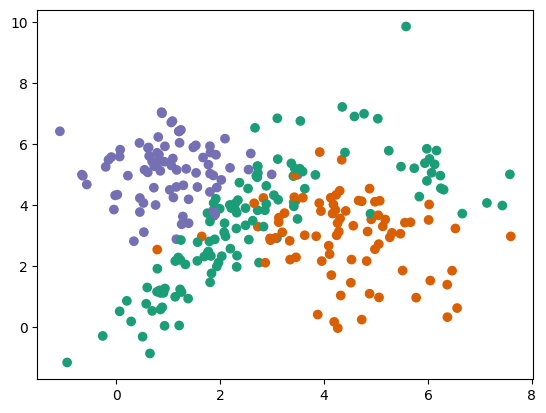

In [2]:
# START TODO ################
# Load and visualize data
data = np.load('../data/dataset.npz')["arr_0"]
labels = data[:, 2]
unique_labels = np.sort(np.unique(labels))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
color_list = [cm.get_cmap('Dark2').colors[label_to_index[label]] for label in labels]
plt.scatter(data[:,0], data[:,1], c=color_list)

In [4]:
# START TODO ################
# Split the data evenly into train and test set

# setting random_state allows us to get the same 
# "random" split everytime we split the data 
# (i.e. same split as in exercise 4)
data_train, data_test = train_test_split(data, test_size=0.5, random_state=42)

# here we check whether the data is equally split 
# between test and train sets
print(np.shape(data))
print(np.shape(data_train))
print(np.shape(data_test))

# here we check how our data looks like
print("\nExample datapoint (x, y, class)")
print(data_train[0])
# END TODO ################


(280, 3)
(140, 3)
(140, 3)

Example datapoint (x, y, class)
[4.23348774 4.32594983 2.        ]


### Run Generative Classifier

In [5]:
# START TODO ################
# Define the generative classifier

def run_gaussian_generative_classifier(data_train, data_test, shared_cov=False):
    # split the train data by class:
    data_train_1 = data_train[data_train[:, 2] == 1]
    data_train_2 = data_train[data_train[:, 2] == 2]
    data_train_3 = data_train[data_train[:, 2] == 3]

    # calculate the mean and cov of the Gaussian class conditionals from the training set:
    mean1 = np.mean(data_train_1[:, :2], axis=0)
    mean2 = np.mean(data_train_2[:, :2], axis=0)
    mean3 = np.mean(data_train_3[:, :2], axis=0)
    
    cov1 = 1/len(data_train_1)*np.dot((data_train_1[:, :2]-mean1).T, (data_train_1[:, :2]-mean1))   
    cov2 = 1/len(data_train_2)*np.dot((data_train_2[:, :2]-mean2).T, (data_train_2[:, :2]-mean2))   
    cov3 = 1/len(data_train_3)*np.dot((data_train_3[:, :2]-mean3).T, (data_train_3[:, :2]-mean3))
    
    # compute shared covariance in case it is assumed that all class conditionals have same covariance:
    if shared_cov:
        cov = (len(data_train_1) * cov1 + len(data_train_2) * cov2 + len(data_train_3) * cov3) / len(data_train)
        cov1 = cov2 = cov3 = cov
    
    # calculate the prior class probabilities(slide 16)
    class_prob_1 = len(data_train_1)/len(data_train)
    class_prob_2 = len(data_train_2)/len(data_train)
    class_prob_3 = len(data_train_3)/len(data_train)
    
    # finished building the model, now evaluate on test data
    x = data_test[:, :2]
    labels_test = data_test[:, 2]

    # use the gaussian to calcualte the probability of x, given a class (slide 15)
    px1 = multivariate_normal.pdf(x, mean1, cov1)  # notation: px1 means p(x|C1)
    px2 = multivariate_normal.pdf(x, mean2, cov2)
    px3 = multivariate_normal.pdf(x, mean3, cov3)

    # use bayes formula to calculate probably of the class , given x
    p1x = px1*class_prob_1/(px1*class_prob_1+px2*class_prob_2+px3*class_prob_3)  # notation: p1x means p(C1|x)
    p2x = px2*class_prob_2/(px1*class_prob_1+px2*class_prob_2+px3*class_prob_3)
    p3x = px3*class_prob_3/(px1*class_prob_1+px2*class_prob_2+px3*class_prob_3)
    
    z = np.stack((p1x, p2x, p3x),axis=1)
    
    # choose the class with largest probability as the predicted label
    labels_pred = np.argmax(z, axis=1) + 1
    
    class_error = np.mean(labels_pred == labels_test)
    print("accuracy:", class_error)

    return labels_pred

# END TODO ################


In [6]:
# START TODO ################
# Define a plot function that plots the predictions and draws a red circle
# around misclassifications

def get_color_map(labels, colormap_name='Dark2'): # convenience function to get a color map for some labels
    label_to_index = {label: idx for idx, label in enumerate(np.sort(np.unique(labels)))}  # map labels to 0-based indices
    class_colors = cm.get_cmap(colormap_name).colors  # use a colormap to get distinct colors for each class
    color_list = [class_colors[label_to_index[label]] for label in labels]  # map labels to colors
    return color_list

def plot_classifier_output(data_test, labels_pred):
    color_list = get_color_map(labels_pred)
    # plot predictions and errors:
    plt.scatter(data_test[:, 0], data_test[:, 1], c=color_list)
    wrong_pred = labels_pred != data_test[:, 2]
    errs = data_test[wrong_pred]
    plt.plot(errs[:, 0], errs[:, 1], linestyle="None", marker = 'o', ms = 15, mec = 'r', mfc = 'None')

# END TODO ################


accuracy: 0.7428571428571429


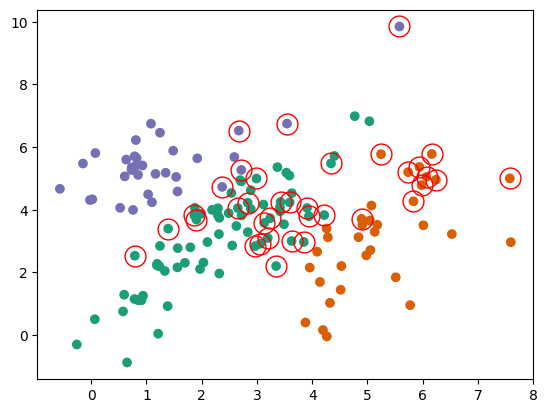

accuracy: 0.8214285714285714


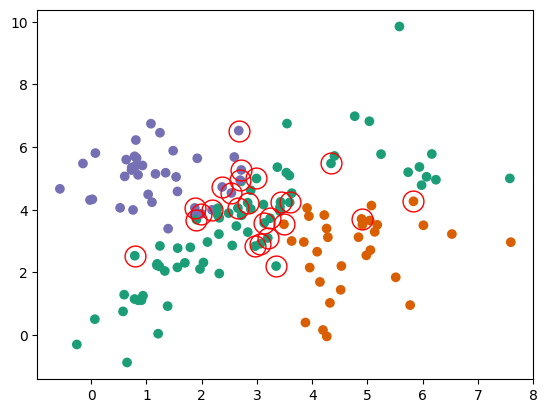

In [7]:
# START TODO ################
# Run and plot the generative classifier

# with shared covariances:
labels_pred = run_gaussian_generative_classifier(data_train, data_test, shared_cov=True)
plot_classifier_output(data_test, labels_pred)
plt.show()

# with class-wise covariances:
labels_pred = run_gaussian_generative_classifier(data_train, data_test)
plot_classifier_output(data_test, labels_pred)
plt.show()

# END TODO ################


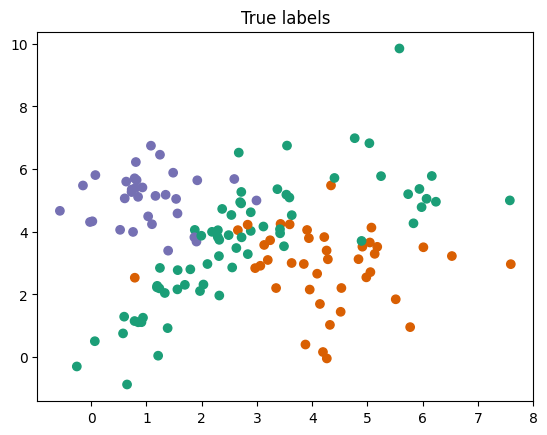

In [8]:
# START TODO ################
# plot true labels for comparison
plt.scatter(data_test[:, 0], data_test[:, 1], c=get_color_map(data_test[:, 2]))
plt.title("True labels")
plt.show()
# END TODO ################


## $\star$ $\star$ Part 2: Discriminative classifier

Train a discriminative classifier via logistic regression and 
$\phi(x) = x$

For optimization use gradient descent.

This corresponds to training a
single layer neural network. 

The cost function is convex, so you will find
the global optimum no matter how you initialize the weights. If your energy
oscillates, you must reduce the step size (learning rate). 

Compute the average classification error and visualize the result. 


In [9]:
# START TODO ################
# Define the optimization of logistic regression
# Show a plot of the accuracy over optimization steps

def softmax(z):
    # softmax function is required rather than sigmoid when there are more than 2 classes (slide 24)
    sm = (np.exp(z).T / np.sum(np.exp(z), axis=1)).T
    return sm

def gradient(X, Y, W):
    # calculates the gradient on the weights to use for gradient decent
    Z = - X @ W
    P = softmax(Z)
    N = X.shape[0]
    grad = 1/N * (X.T @ (Y - P))
    return grad

def get_labels(data_test, W):
    data_test = data_test[:, :2]
    
    Z = - data_test @ W
    P = softmax(Z)
    labels_pred = np.argmax(P, axis=1) + 1
    return labels_pred

def run_logistic_regression(data_train, data_test, learning_rate, iterations, plot=True):
    x = data_train[:, :2]
    y = data_train[:, 2]
    labels_test = data_test[:, 2]

    # apply one hot encoding to the labels
    Y_onehot = onehot_encoder.fit_transform(y.reshape(-1, 1))
    
    # initialize W
    W = np.zeros((x.shape[1], Y_onehot.shape[1]))
    
    # train model via gradient descent
    accuracy_lst = []
    for i in range(iterations):
        W -= learning_rate * gradient(x, Y_onehot, W)
        labels_pred = get_labels(data_test, W)
        # caclulate the accuracy
        acc = np.mean(labels_pred == labels_test)
        accuracy_lst.append(acc)

    if plot:
        plt.plot(accuracy_lst, label=f"lr={learning_rate}")
    print("final accuracy:", acc)
    
    return labels_pred

# END TODO ################


final accuracy: 0.5928571428571429
final accuracy: 0.7642857142857142
final accuracy: 0.7714285714285715
final accuracy: 0.7071428571428572


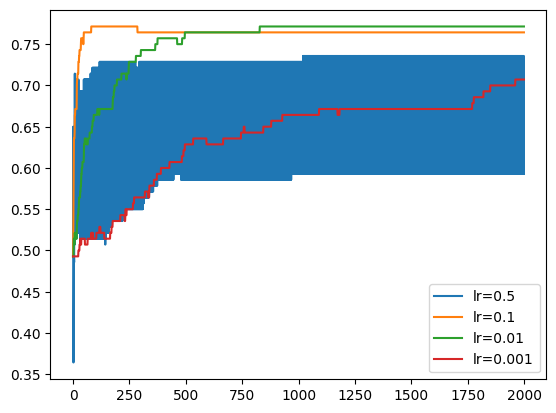

In [11]:
# START TODO ################
# Try various learning rates ("Hyper-parameter" search). 
# With which lr does training oscillate?
for lr in (.5, .1, .01, .001):
    run_logistic_regression(data_train, data_test, lr, 2000)
plt.legend()
# END TODO ################


final accuracy: 0.7714285714285715


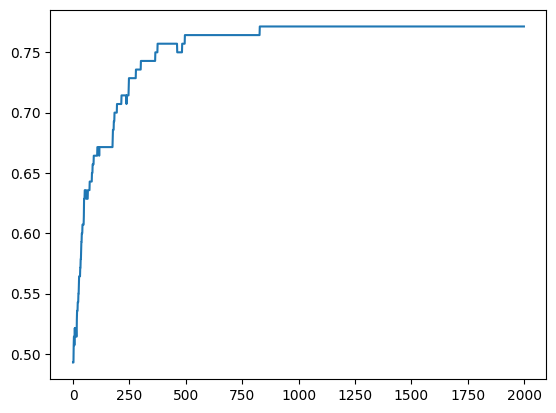

In [12]:
# START TODO ################
# Run the optimization again with the best learning rate you found
labels_pred = run_logistic_regression(data_train, data_test, .01, 2000)
# END TODO ################


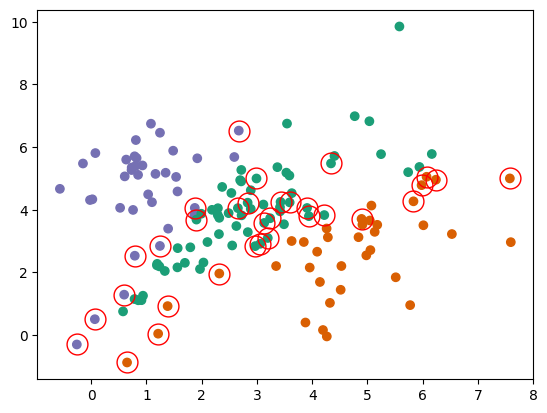

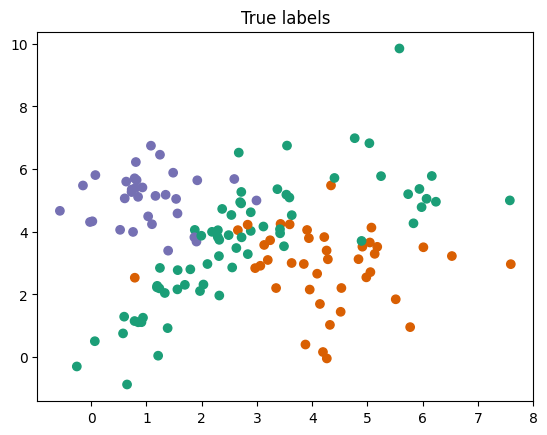

In [13]:
# START TODO ################
# As above, plot predictions, errors and true labels.
plot_classifier_output(data_test, labels_pred)
plt.show()

plt.scatter(data_test[:, 0], data_test[:, 1], c=get_color_map(data_test[:, 2]))
plt.title("True labels")
plt.show()
# END TODO ################
